# Advanced Lane Finding

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [21]:
import glob  # OS dependencies to get file system details
import os
import cv2
# importing some useful packages
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from moviepy.editor import VideoFileClip
%matplotlib inline

In [22]:
# STEP 1: Camera Calibration
# Loading test images from test_image directory
images = [mpimg.imread(path) for path in glob.glob("camera_cal/*")]

In [23]:
def show_images(images, gray=None, divider=2):
    """
    This is an utility function to show multiple images with different colour maps
    :param images - An images list
    :param gray - A flag to set default value for matplotlib imshow colour map. If the image
                  shape is 2( i.e binary image) then cmap value will be "gray"
    :return: Nothing
    """
    rows = (len(images) + 1) // divider
    plt.figure(figsize=(20, 20))
    for idx, img in enumerate(images):

        plt.subplot(rows, divider, idx + 1)
        # if the image is binary then it'll be printed as grayscale, otherwise colour map
        # will be ignored
        plt.imshow(img, cmap="gray" if len(img.shape) == 2 else gray)
        plt.xticks([])
        plt.yticks([])

    plt.show()

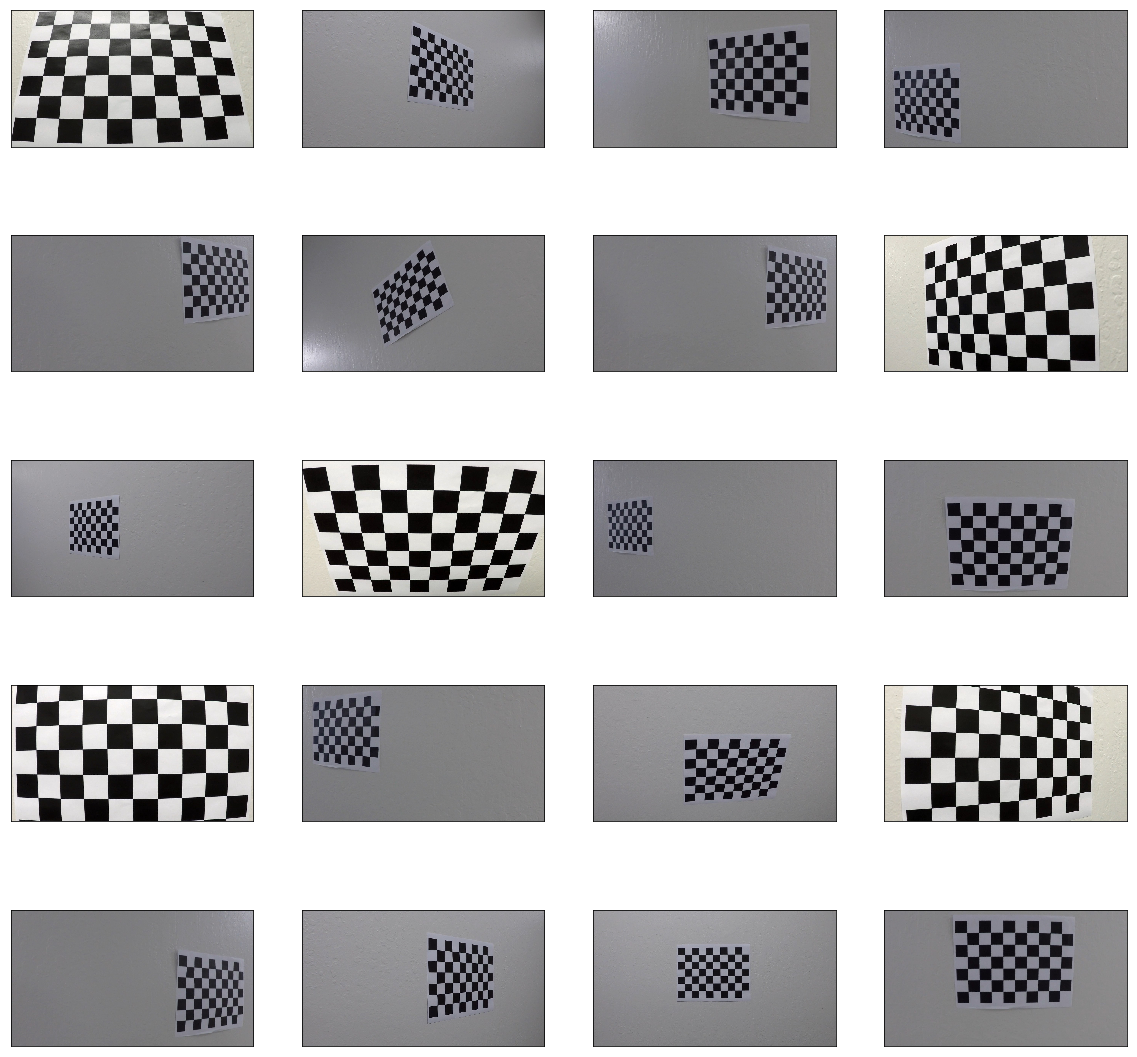

In [24]:
# Visualize calibration images

show_images(images, divider=4)

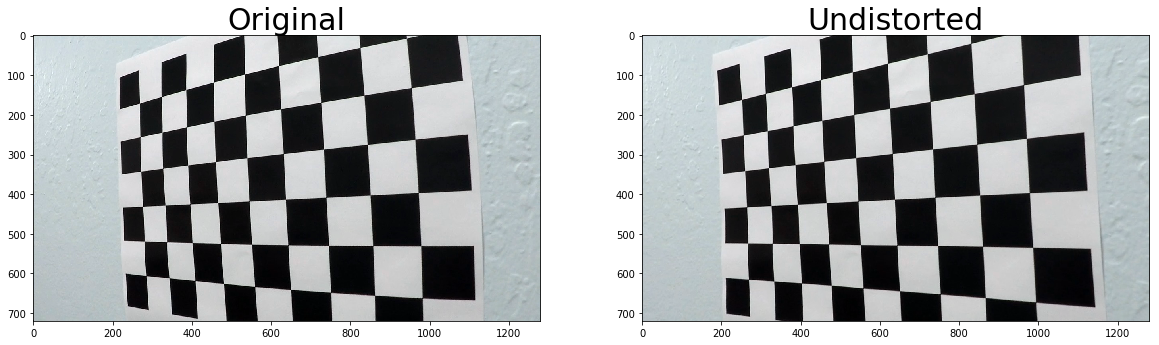

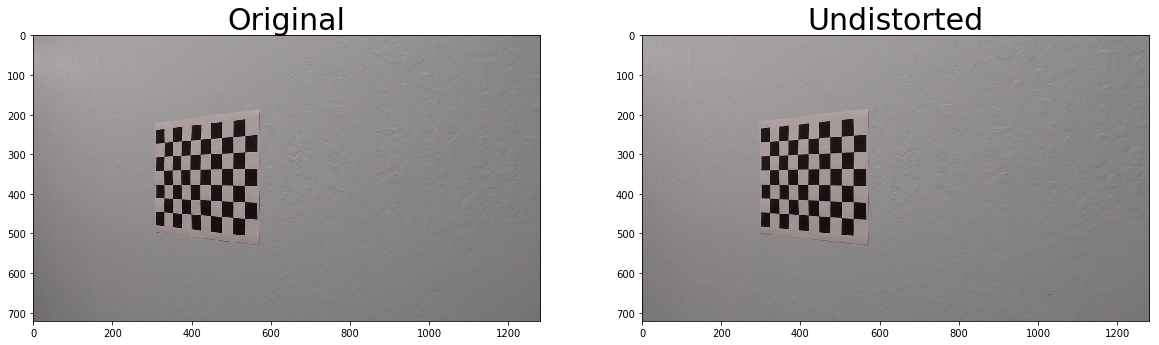

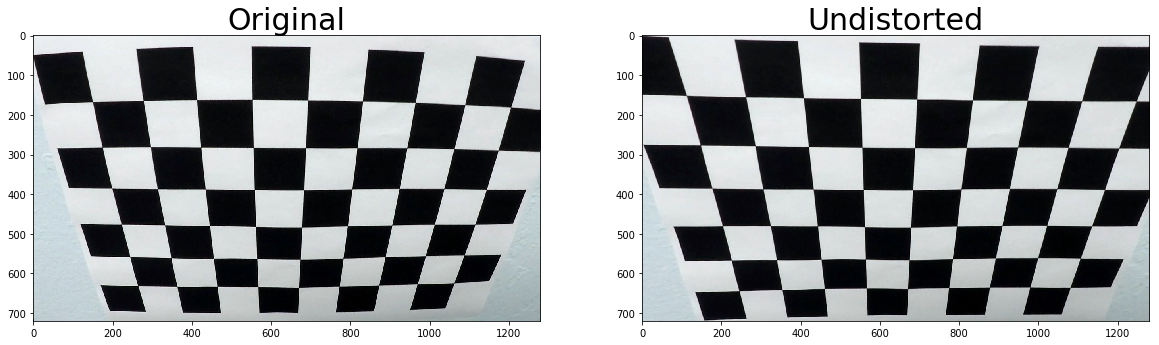

In [25]:
# Visualize corner identifiers on calibration images 
# These are camera calibartion factors / metrics
mtx = None
dist = None

# Make a list of calibration images
calib_images = glob.glob('camera_cal/calibration*.jpg')
def get_calibration_factors():

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners

    plt.figure(figsize=(20, 20))

    for fname in calib_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

mtx, dist = get_calibration_factors()

for fname in calib_images[7:10]:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

    # show original image
    if len(img.shape) == 2:
        ax1.imshow(img, cmap='gray')
    else:
        ax1.imshow(img)
    ax1.set_title("Original", fontsize=30)

    # show undistorted image
    if len(undst.shape) == 2:
        ax2.imshow(undst, cmap='gray')
    else:
        ax2.imshow(undst)
    ax2.set_title("Undistorted", fontsize=30)
        
plt.show()
    



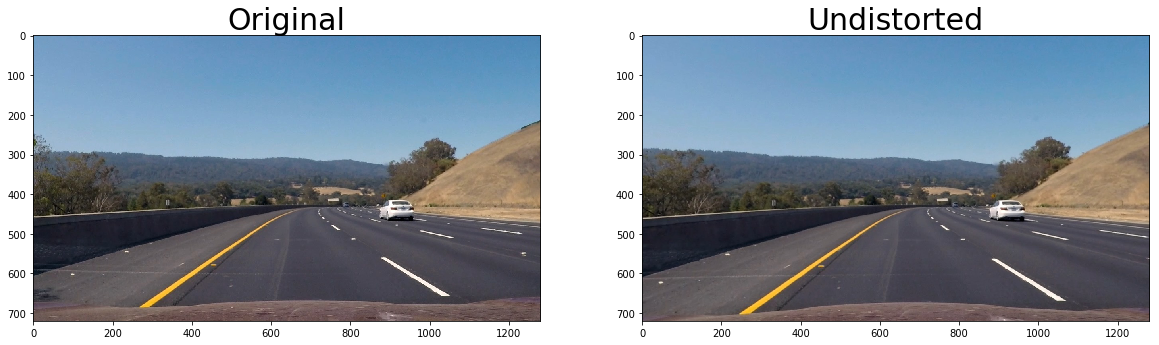

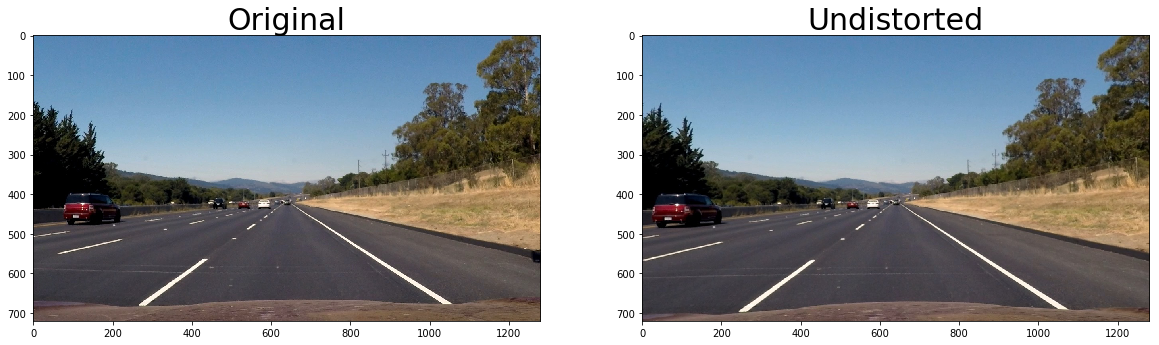

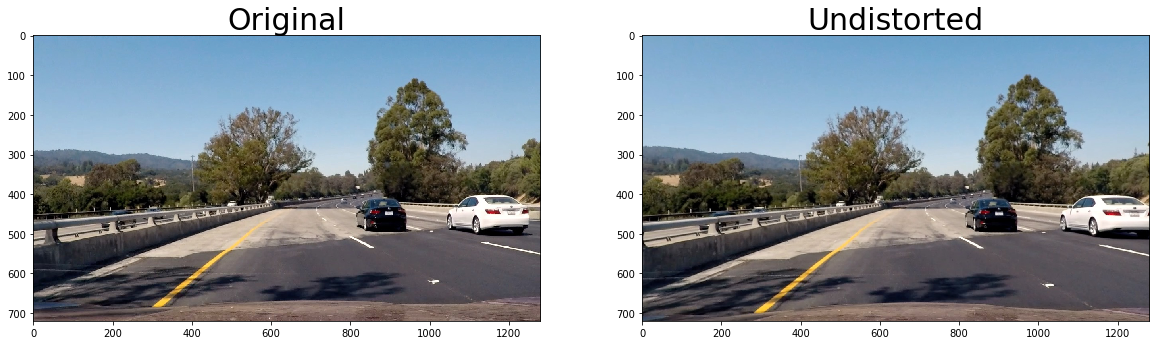

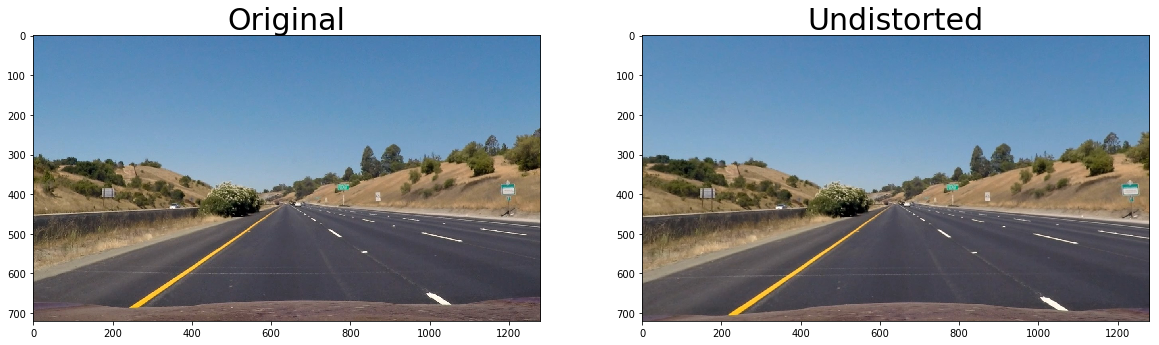

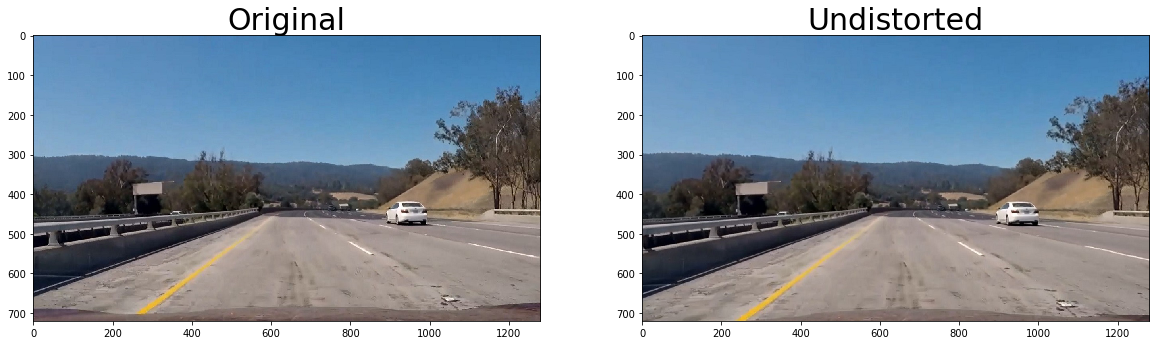

In [26]:
test_images = [mpimg.imread(path) for path in glob.glob("test_images/*")]

mtx, dist = get_calibration_factors()

for img in test_images[1:6]:
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

    # show original image
    if len(img.shape) == 2:
        ax1.imshow(img, cmap='gray')
    else:
        ax1.imshow(img)
    ax1.set_title("Original", fontsize=30)

    # show undistorted image
    if len(undst.shape) == 2:
        ax2.imshow(undst, cmap='gray')
    else:
        ax2.imshow(undst)
    ax2.set_title("Undistorted", fontsize=30)
        
plt.show()

In [27]:

def transform_perspective(image):
    
    height, width = img.shape[0], img.shape[1]
    
    # Quadrangle vertices coordinates in the source image
    src1 = [width // 2 - 76, height * 0.625]
    src2 = [width // 2 + 76, height * 0.625]
    src3 = [-100, height]
    src4 = [width + 100, height]
    src = np.float32([src1, src2, src3, src4])
 
    # Quadrangle verties coordinates in the destination image
    dst1 = [100, 0]
    dst2 = [width - 100, 0]
    dst3 = [100, height]
    dst4 = [width - 100, height]
    dst = np.float32([dst1, dst2, dst3, dst4])

    # Given src and dst points we calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image
    warped = cv2.warpPerspective(image, M, (width, height))
    # We also calculate the oposite transform
    unwrap_m = cv2.getPerspectiveTransform(dst, src)
    # Return the resulting image and matrix 
    return warped, unwrap_m

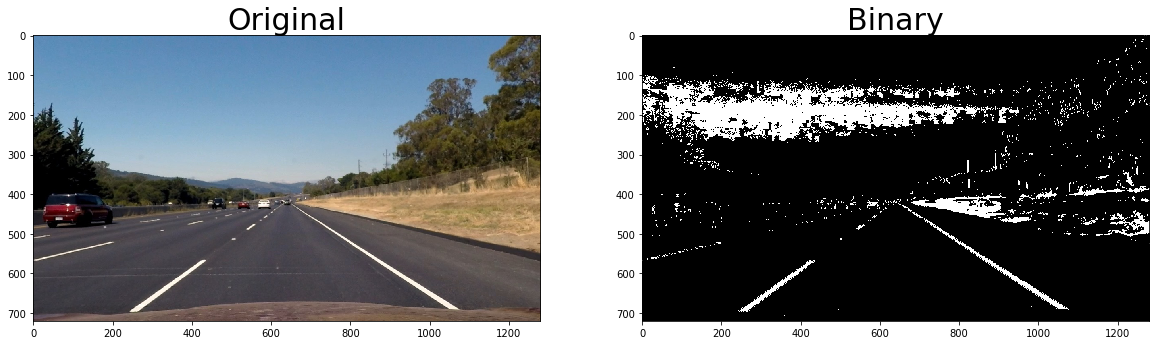

In [28]:
# takes undistorted image as input
def get_binary_image(img_undist, s_thresh=(100, 255), sx_thresh=(40, 100)):  
    gray = cv2.cvtColor(img_undist,cv2.COLOR_RGB2GRAY)

    # Convert to HLS color space and separate the all channels
    hls = cv2.cvtColor(img_undist, cv2.COLOR_RGB2HLS)

    h_channel = hls[:, :, 0] # Hue channel
    l_channel = hls[:, :, 1] # Lightness channel
    s_channel = hls[:, :, 2] # Satuaration channel
        
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    
    # Sobel gives -ve derivative when transition is from light pixels to dark pixels
    # so taking absolute values which just indicates strength of edge
    abs_sobelx = np.absolute(sobelx)
    
    # For consistency rescaling pixel values by mapping maximum pixel value in image to 255
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
#     h_binary =  np.zeros_like(h_channel)
#     # Detect pixels that are yellow using the hue component
#     h_binary[(h_channel > 10) & (h_channel <= 25)] = 1

    #Using the l channel to remove shadows which it used to interpret as lane lines
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel>150)]= 1
    
   
    combined_binary = np.zeros_like(sxbinary)
    
    # making all the pixel 1 which are either part of x gradient thresholded image or color channel thresholded image
    combined_binary[((l_binary == 1) & (s_binary == 1)) | (sxbinary == 1) ] = 1
    
    return combined_binary


test_images = [mpimg.imread(path) for path in glob.glob("test_images/*")]

for img in test_images[2:3]:
    
    #undistort
    
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    #get binary after color and gradient threshold checks
    result = get_binary_image(undst)
#     warped, unwarped_m = transform_perspective(undst)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

    # show original image
    if len(undst.shape) == 2:
        ax1.imshow(undst, cmap='gray')
    else:
        ax1.imshow(undst)
    ax1.set_title("Original", fontsize=30)


    # show undistorted image
    if len(result.shape) == 2:
        ax2.imshow(result, cmap='gray')
    else:
        ax2.imshow(result)
    ax2.set_title("Binary", fontsize=30)

        
plt.show()


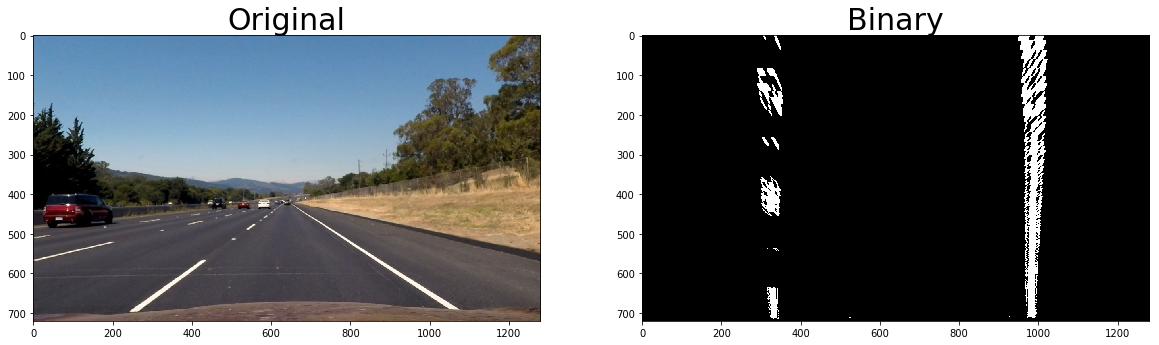

In [29]:
test_images = [mpimg.imread(path) for path in glob.glob("test_images/*")]

for img in test_images[2:3]:
    
    #undistort
    
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    #get binary after color and gradient threshold checks
    result = get_binary_image(undst)
    warped, unwarped_m = transform_perspective(result)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

    # show original image
    if len(undst.shape) == 2:
        ax1.imshow(undst, cmap='gray')
    else:
        ax1.imshow(undst)
    ax1.set_title("Original", fontsize=30)


    # show undistorted image
    if len(warped.shape) == 2:
        ax2.imshow(warped, cmap='gray')
    else:
        ax2.imshow(warped)
    ax2.set_title("Binary", fontsize=30)

        
plt.show()

In [30]:
def image_pipeline(img, mtx, dist):
    
    # undistort
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    #get binary after color and gradient threshold checks
    result = get_binary_image(undst)
    
    # transform perspective 
    warped, unwarp_m = transform_perspective(result)

    #just send back the warped image
    return warped, unwarp_m
    
    

In [31]:
def get_histogram(image):
    
    # get the bottom half of the binary gray image showing lanes 
    bottom_half = image[image.shape[0]//2:, :]
    
    # calculate the sum of the image pixels vertically. Along the white lanes the highest areas on histogram will show up
    hist = np.sum(bottom_half, axis=0 ) 
    
    return hist
    

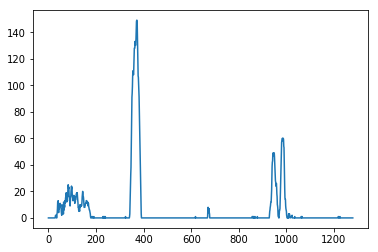

In [32]:
test_images =  glob.glob("test_images/*")
#test_images = [mpimg.imread(path) for path in glob.glob("test_images/*")]

img = cv2.imread(test_images[5])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

bimage, unwarp_m = image_pipeline(img, mtx, dist)
hist = get_histogram(bimage)
plt.plot(hist)

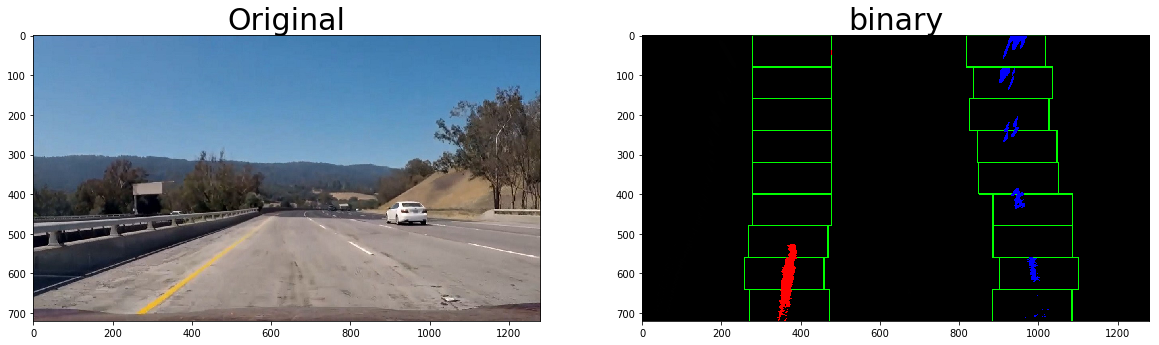

In [33]:

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    marginleft = midpoint//10

    leftx_base = np.argmax(histogram[:midpoint])

    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
                       ## DONE
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]


    return out_img

   
test_images = [mpimg.imread(path) for path in glob.glob("test_images/*")]

for img in test_images[5:6]:
    bimage, unwarp_m = image_pipeline(img, mtx, dist)
    out_img = fit_polynomial(bimage)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

    # show original image
    if len(img.shape) == 2:
        ax1.imshow(img, cmap='gray')
    else:
        ax1.imshow(img)
    ax1.set_title("Original", fontsize=30)

    # show undistorted image
    if len(out_img.shape) == 2:
        ax2.imshow(out_img, cmap='gray')
    else:
        ax2.imshow(out_img)
    ax2.set_title("binary", fontsize=30)
    plt.imshow(out_img)

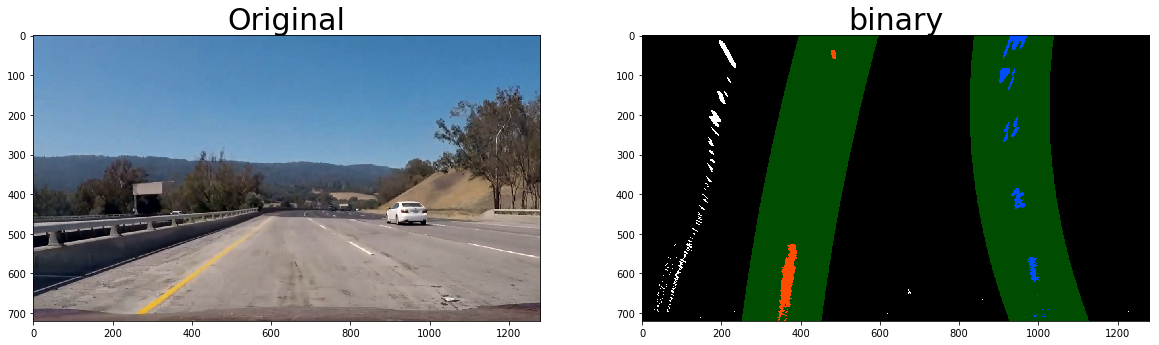

In [34]:

# Load our image - this should be a new frame since last time!


# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])


def fit_poly(img_shape, leftx, lefty, rightx, righty):

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))


    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    ret = {}
    ret['left_lane_inds'] = left_lane_inds
    ret['right_lane_inds'] = right_lane_inds
    ret['nonzerox'] = nonzerox
    ret['nonzeroy'] = nonzeroy
    
    return result, ret



def measure_curve_on_road(left_lane_inds, right_lane_inds, nonzerox, nonzeroy):
    """
    Calculate radius of lane curvature in meters
    """
    y_eval = 719  # 720p video/image, so last (lowest on screen) y index is 719

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    return left_curverad, right_curverad

def get_vehicle_offset(undist, left_fit, right_fit):
    """
    Calculate vehicle offset from lane center in meters
    """
    # Calculate vehicle center offset in pixels
    bottom_y = undist.shape[0] - 1
    bottom_x_left = left_fit[0]*(bottom_y**2) + left_fit[1]*bottom_y + left_fit[2]
    bottom_x_right = right_fit[0]*(bottom_y**2) + right_fit[1]*bottom_y + right_fit[2]
    vehicle_offset = undist.shape[1]/2 - (bottom_x_left + bottom_x_right)/2

    # Convert pixel offset to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    vehicle_offset *= xm_per_pix

    return vehicle_offset

def final_image_with_textinfo(undist, left_fit, right_fit, m_inv, left_curve, right_curve, vehicle_offset):

    # Generate x and y values for plotting
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    image_shape = undist.shape
    color_warp = np.zeros(image_shape, dtype='uint8')

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (undist.shape[1], undist.shape[0]))
 
    # Annotate lane curvature values and vehicle offset from center
    avg_curve = (left_curve + right_curve)/2
    label_str = 'Radius of curvature = %.1f m' % avg_curve
    result = cv2.putText(newwarp, label_str, (30,40), 0, 1, (250,250,0), 2, cv2.LINE_AA)

    label_str = 'Vehicle is %.1f m from the center ' % vehicle_offset
    result = cv2.putText(newwarp, label_str, (30,70), 0, 1, (250,250,0), 2, cv2.LINE_AA)

    return result


test_images = [mpimg.imread(path) for path in glob.glob("test_images/*")]

# step 1: camera calibration
mtx, dist = get_calibration_factors()

for timg in test_images[5:6]:
    
    # step # 2 undistort the image
    undst = cv2.undistort(timg, mtx, dist, None, mtx)
    
    #get binary after color and gradient threshold checks
    undist_bimage = get_binary_image(undst)
    
    # transform perspective 
    warped_bimage, unwarp_m = transform_perspective(undist_bimage)
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_bimage)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
    # mark lanes after polynomial fitting
    lanes_marked, retvals = search_around_poly(warped_bimage)
#     left_curve, right_curve = measure_curve_on_road(retvals['left_lane_inds'], retvals['right_lane_inds'], retvals['nonzerox'], retvals['nonzeroy'])
#     vehicle_offset = get_vehicle_offset(lanes_marked,left_fit,right_fit)
    
#     newwarp = final_image_with_textinfo(lanes_marked, left_fit, right_fit, unwarp_m, left_curve, right_curve, vehicle_offset)

#     result = cv2.addWeighted(lanes_marked, 1, newwarp, 0.5, 0)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

    # show original image
    if len(img.shape) == 2:
        ax1.imshow(img, cmap='gray')
    else:
        ax1.imshow(img)
    ax1.set_title("Original", fontsize=30)

    # show undistorted image
    if len(lanes_marked.shape) == 2:
        ax2.imshow(lanes_marked, cmap='gray')
    else:
        ax2.imshow(lanes_marked)
    ax2.set_title("binary", fontsize=30)
    plt.imshow(lanes_marked)
 
  
 

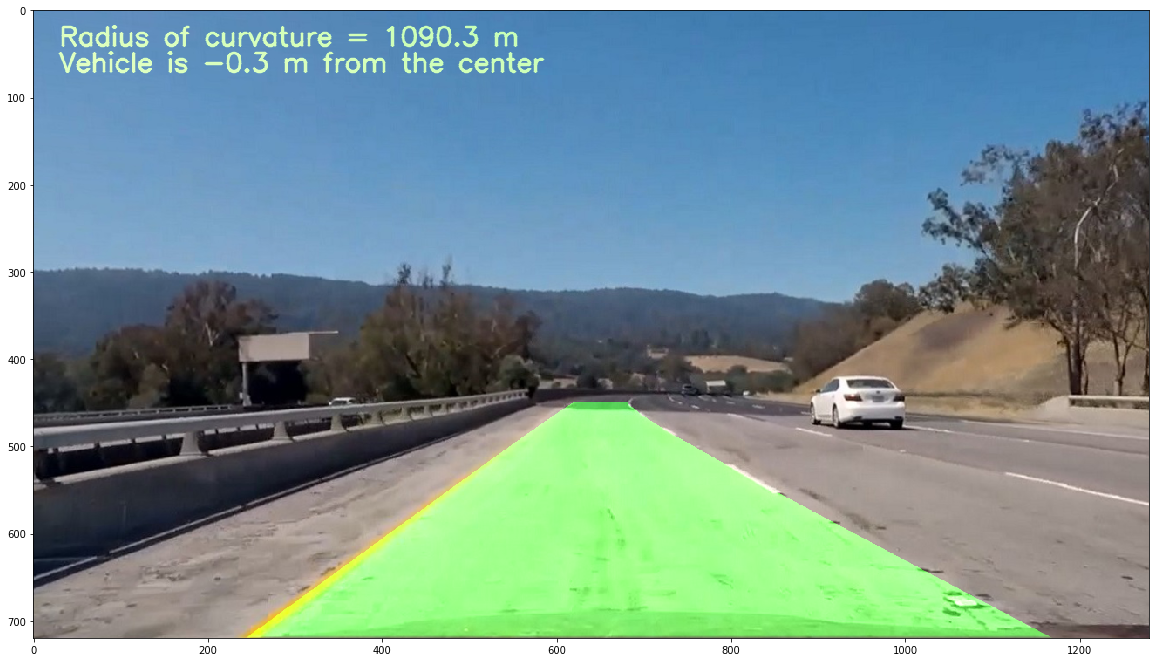

In [35]:
test_images = [mpimg.imread(path) for path in glob.glob("test_images/*")]

# step 1: camera calibration
mtx, dist = get_calibration_factors()

for timg in test_images[5:6]:
    
    # step # 2 undistort the image
    undst = cv2.undistort(timg, mtx, dist, None, mtx)
    
    #get binary after color and gradient threshold checks
    undist_bimage = get_binary_image(undst)
    
    # transform perspective 
    warped_bimage, unwarp_m = transform_perspective(undist_bimage)
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_bimage)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
    # mark lanes after polynomial fitting
    lanes_marked, retvals = search_around_poly(warped_bimage)
    left_curve, right_curve = measure_curve_on_road(retvals['left_lane_inds'], retvals['right_lane_inds'], retvals['nonzerox'], retvals['nonzeroy'])
    vehicle_offset = get_vehicle_offset(lanes_marked,left_fit,right_fit)
    
    newwarp = final_image_with_textinfo(lanes_marked, left_fit, right_fit, unwarp_m, left_curve, right_curve, vehicle_offset)

    result = cv2.addWeighted(undst, 1, newwarp, 0.5, 0)

    plt.imshow(result)
  

In [36]:
leftx = None
lefty = None
def find_lane_pipeline_video(img):
    global leftx
    global lefty
    
    # step # 2 undistort the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    #get binary after color and gradient threshold checks
    undist_bimage = get_binary_image(undist)
    
    # transform perspective 
    warped_bimage, unwarp_m = transform_perspective(undist_bimage)
        
    # mark lanes after polynomial fitting
    lanes_marked, retvals = search_around_poly(warped_bimage)
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_bimage)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_curve, right_curve = measure_curve_on_road(retvals['left_lane_inds'], retvals['right_lane_inds'], retvals['nonzerox'], retvals['nonzeroy'])
    vehicle_offset = get_vehicle_offset(lanes_marked,left_fit,right_fit)
    
    newwarp = final_image_with_textinfo(lanes_marked, left_fit, right_fit, unwarp_m, left_curve, right_curve, vehicle_offset)

    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    return result




In [ ]:
video_output =  'project_output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(find_lane_pipeline_video)
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_output_video.mp4
[MoviePy] Writing video project_output_video.mp4



 81%|████████  | 1022/1261 [03:26<00:54,  4.41it/s]

In [ ]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [201]:
harder_video_output =  'harder_project_video.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
output_clip = clip1.fl_image(find_lane_pipeline_video)
%time output_clip.write_videofile(harder_video_output, audio=False)

[MoviePy] >>>> Building video harder_project_video.mp4
[MoviePy] Writing video harder_project_video.mp4


 50%|█████     | 606/1200 [02:29<01:57,  5.07it/s]

TypeError: expected non-empty vector for x

In [194]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_video_output))

In [19]:
challenge_video_output =  'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video_org.mp4")
output_clip = clip1.fl_image(find_lane_pipeline_video)
%time output_clip.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


 12%|█▏        | 56/485 [00:08<01:28,  4.82it/s]

TypeError: expected non-empty vector for x

In [18]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))